In [1]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
from torchvision.transforms import *


transform=transforms.Compose(
    [
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.GaussianBlur(kernel_size=(3,3)),
    transforms.RandomAffine((0,180),(0.1,0.2)),
    transforms.ToTensor(),
    ]
)
from torch.utils.data import DataLoader
import numpy as np


In [2]:
data_dir = r"C:\Users\HARRY\Desktop\cassava-leaf-disease-classification"  #data path
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
one  = df_train[df_train['label'] == 0].values
two  = df_train[df_train['label'] == 1].values
three = df_train[df_train['label'] == 2].values
four  = df_train[df_train['label'] == 3].values
five  = df_train[df_train['label'] == 4].values
images = [one[0][0],two[0][0],three[0][0],four[0][0],five[0][0]]

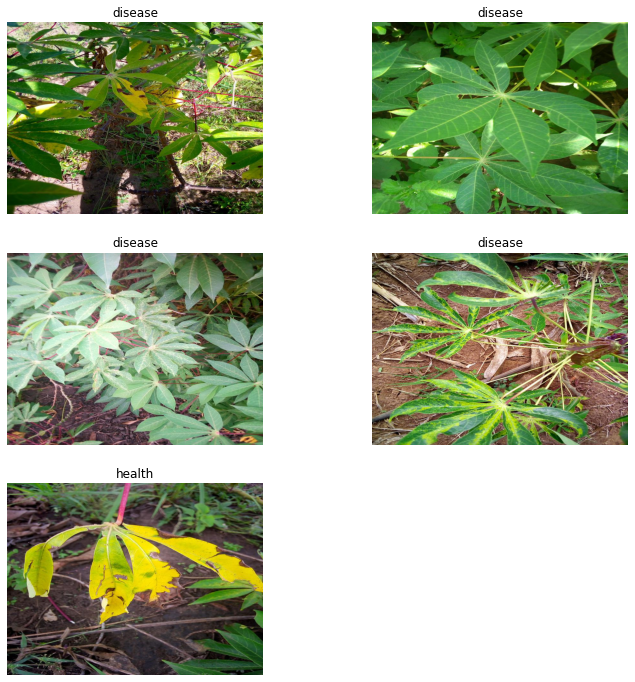

In [4]:
import os
import matplotlib.pyplot as plt
import cv2
image_folder = r'C:\Users\HARRY\Desktop\cassava-leaf-disease-classification\train_images'
plt.figure(figsize=(12,12))
for i,image_path in enumerate(images):
  image = Image.open(os.path.join(image_folder,image_path))
  ax = plt.subplot(3,2,i+1)
  if i+1 == 5:
    plt.title('health')
  else:
    plt.title("disease")
  plt.imshow(image)
  plt.axis('off')

In [5]:
print(len(df_train["label"].values))
print(set(df_train["label"].values))

21397
{0, 1, 2, 3, 4}


<AxesSubplot:title={'center':'Dataset distribution'}>

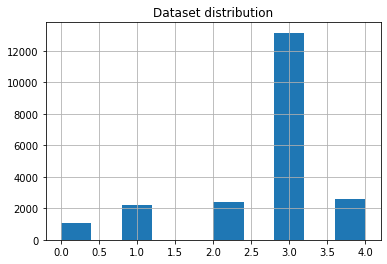

In [6]:

plt.title('Dataset distribution')
df_train['label'].hist()

In [8]:
Series  = df_train[df_train['label'] == 3].sample(2000)
Series.head()

,image_id,label
16136,390671974.jpg,3
5198,1928471334.jpg,3
8970,2587457959.jpg,3
13857,3478004447.jpg,3
13173,3359054336.jpg,3


array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

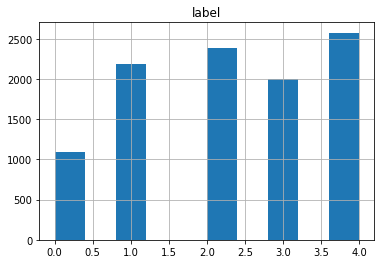

In [9]:
df_train = df_train.drop((df_train[df_train['label'] == 3]).index)
df_train = pd.concat([df_train,Series])
df_train.hist()

In [7]:
#load Dataset

class LEAFDataset(Dataset):
    def __init__(self, df, transforms=None):

        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        image_file = os.path.join(image_folder, img_id)
        image=Image.open(image_file)
        
        if self.transforms is not None:
            image = self.transforms(image)
        image = np.array(image).astype(np.float32)
        image /= 255
        

        return torch.tensor(image), torch.tensor(row.label)

In [8]:
from torchvision.models import resnet50
model = resnet50(True)
model.fc = nn.Linear(2048,5)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
#train model 
import pytorch_warmup as warmup
import sys
true_label=[]
pre_label=[]
learning_rate = 0.001
EPOCH = 40

opti = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
loss_function=nn.CrossEntropyLoss()
choose = 0
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[EPOCH//3], gamma=0.1)
# warmup_scheduler = warmup.UntunedLinearWarmup(opti)
# warmup_scheduler.last_step = -1 # initialize the step counter
def train(*,epoch, model, train_dataset, loss_function, optimizer):
    sum_loss = 0
    for i,data in enumerate(train_dataset):
        # lr_scheduler.step(epoch-1)
        # warmup_scheduler.dampen()
        optimizer.zero_grad()
        features, labels = data
        features=features.cuda()
        labels=labels.cuda()
        out = model(features)
        loss = loss_function(out, labels)
        sum_loss += loss.item()
        sys.stdout.write("\r{0}".format(
                "{}/{}".format(i+1, len(train_dataset))))
        loss.backward()
        optimizer.step()
    return float(sum_loss/len(train_dataset))


def test(*, model, test_dataset, train_dataset):
    def check(dataset):
        right = 0
        total = 0
        with torch.no_grad():
            for data in dataset:
                image, label = data
                true_label.append(label)
                image = image.cuda()
                label = label.cuda()
                out = model(image)
                total = total+out.size(0)
                _, index = torch.max(out.data, dim=1)
                pre_label.append(index)
                right += (index == label).sum().item()
        return float(right / total)
    return check(train_dataset), check(test_dataset)
print("done")

done


In [10]:
full_dataset=LEAFDataset(df_train,transform)
size = int(0.1*len(full_dataset))
split_size = [size for i in range(9)]
split_size.append(len(full_dataset)-sum(split_size))
Datasets = torch.utils.data.random_split(
    full_dataset,split_size,generator=torch.Generator().manual_seed(42))
for idx,d in enumerate(Datasets):
  print("Dataset {} : length : {}".format(idx,len(d)))

Dataset 0 : length : 2139
Dataset 1 : length : 2139
Dataset 2 : length : 2139
Dataset 3 : length : 2139
Dataset 4 : length : 2139
Dataset 5 : length : 2139
Dataset 6 : length : 2139
Dataset 7 : length : 2139
Dataset 8 : length : 2139
Dataset 9 : length : 2146


In [11]:
BATCH_SIZE  = 64
DataLoaders = [DataLoader(d,batch_size=BATCH_SIZE,shuffle=True) for d in Datasets]

In [12]:
def ChooseDataset(index):
  test_dataset = None
  train_datasets = []
  for i in range(len(DataLoaders)):
    if index == i:
      test_dataset = DataLoaders[i]
    else:
      train_datasets.append(DataLoaders[i])
  return train_datasets,test_dataset

In [13]:
#Setting parameters

train_acc_list = []
test_acc_list  =[]
loss_list =[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
for i in range(EPOCH):
    if choose % 10 == 0:
        choose = 0
    train_datasets,test_dataset = ChooseDataset(choose)
    choose+=1
    train_loss = 0.0
    for train_dataset in train_datasets:
      train_loss += train(epoch = i+1,model = model,train_dataset=train_dataset,loss_function=loss_function,optimizer=opti)
    train_acc,test_acc = test(model=model,test_dataset=test_dataset,train_dataset=train_datasets[np.random.randint(0,8)])
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    loss_list.append(float(train_loss/9))
    print("\n E:{}  acc={}(on train_dataset) acc={}(on test_dataset) loss={}".format(i+1,train_acc,test_acc,float(train_loss/9)))

C:\Users\HARRY\.conda\envs\Comp9444\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\HARRY\.conda\envs\Comp9444\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate 

34/34
 E:1  acc=0.7900888265544647(on train_dataset) acc=0.7737260402057036(on test_dataset) loss=0.8021055298303468
34/34
 E:2  acc=0.7821411874707808(on train_dataset) acc=0.7788686302010285(on test_dataset) loss=0.6162474523572361
34/34
 E:3  acc=0.7947639083683965(on train_dataset) acc=0.7952314165497896(on test_dataset) loss=0.6067612093258528
34/34
 E:4  acc=0.7835437120149603(on train_dataset) acc=0.788218793828892(on test_dataset) loss=0.6044509226784986
34/34
 E:5  acc=0.7779336138382422(on train_dataset) acc=0.7844787283777466(on test_dataset) loss=0.6033349543615104
34/34
 E:6  acc=0.7975689574567555(on train_dataset) acc=0.7849462365591398(on test_dataset) loss=0.604640157491553
34/34
 E:7  acc=0.7788686302010285(on train_dataset) acc=0.7821411874707808(on test_dataset) loss=0.6019941771926445
34/34
 E:8  acc=0.7919588592800374(on train_dataset) acc=0.7905563347358578(on test_dataset) loss=0.5810066659271328
34/34
 E:9  acc=0.7928938756428238(on train_dataset) acc=0.8167367

In [56]:
path = r"C:\Users\HARRY\Desktop\Resnet50+warm-up 不完整数据集\model3.pth"
# torch.save(model.state_dict(),path)

In [57]:
test_model = resnet50(False)
test_model.fc = nn.Linear(2048,5)
test_model.load_state_dict(torch.load(path))
test_model = test_model.to(device)

In [46]:
def test_network(net,testloader):
    net.eval()
    total_images = 0
    total_correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    print('      Accuracy on {0} test images: {1:.2f}%'.format(
                                total_images, model_accuracy))
    net.train()
    return model_accuracy
def predict(net,testloader):
    net.eval()
    total_images = 0
    total_correct = 0
    predict = []
    true    = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            predict += predicted.cpu().numpy().tolist()
            true    += labels.cpu().numpy().tolist()
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    net.train()
    return predict,true

In [17]:
test_accuracy = []
for dataset in DataLoaders:
    test_accuracy.append(test_network(test_model,dataset))

      Accuracy on 2139 test images: 86.26%
      Accuracy on 2139 test images: 86.77%
      Accuracy on 2139 test images: 86.68%
      Accuracy on 2139 test images: 87.52%
      Accuracy on 2139 test images: 86.86%
      Accuracy on 2139 test images: 86.82%
      Accuracy on 2139 test images: 87.38%
      Accuracy on 2139 test images: 87.24%
      Accuracy on 2139 test images: 89.20%
      Accuracy on 2146 test images: 88.16%


In [19]:
plt.style.use('bmh')

In [20]:
test_accuracy

[86.25525946704067,
 86.76951846657317,
 86.67601683029453,
 87.51753155680224,
 86.86302010285179,
 86.81626928471248,
 87.37727910238429,
 87.23702664796635,
 89.20056100981768,
 88.16402609506058]

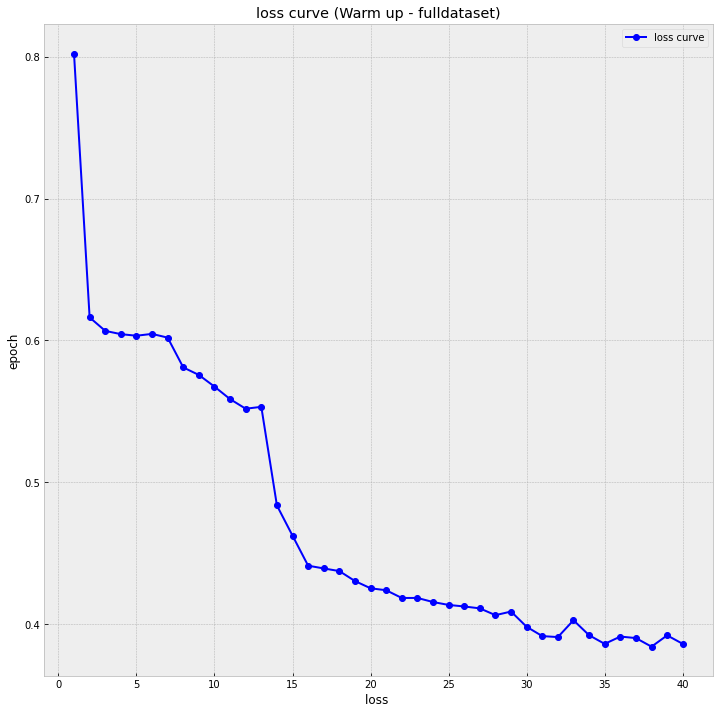

In [23]:
plt.figure(figsize = (12,12))
plt.title("loss curve (Warm up - fulldataset)")
plt.plot(range(1,len(loss_list)+1),loss_list,'o-',color= 'b',label = 'loss curve')
#plt.plot(range(1,len(train_acc_list)+1),train_acc_list,'o-',color= 'r',label = 'train-accuracy')
plt.xlabel("loss ")
plt.ylabel("epoch")
plt.legend()
plt.savefig("loss curve(resnet50-fulldata-warmup).jpg")

In [58]:
pred,true = predict(test_model,DataLoaders[0])

[[0.56 0.14 0.03 0.01 0.27]
 [0.01 0.84 0.04 0.01 0.09]
 [0.   0.04 0.83 0.05 0.08]
 [0.01 0.03 0.08 0.81 0.06]
 [0.05 0.07 0.09 0.01 0.77]]


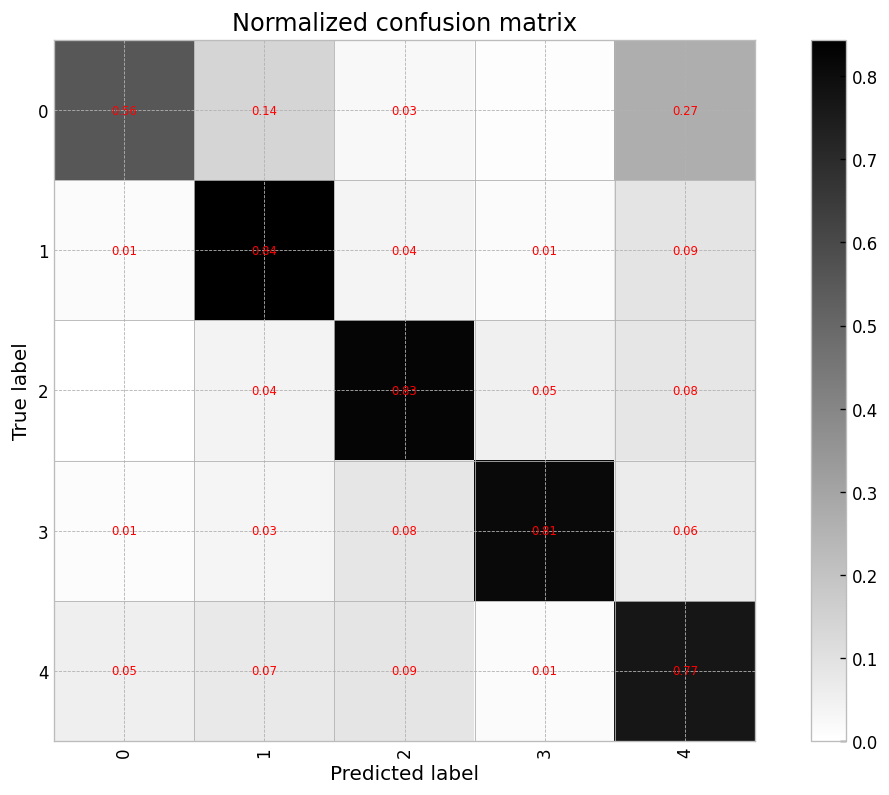

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = [str(i) for i in range(5)]

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if c > 0.01:
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig("confusion matrix (non-fulldataset-warmup).jpg")